In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [5]:
training_dict = np.load("py3_training_dict.npy").item()

In [6]:
training_dict.keys()

dict_keys(['training_x', 'training_regress', 'training_class'])

In [7]:
training_x = training_dict['training_x']
training_regress = training_dict['training_regress']
training_class = training_dict['training_class']

In [8]:
mask = np.isnan(training_regress)

In [9]:
X = np.array(training_x)[~mask]
y = np.array(training_regress)[~mask]

In [10]:
test_X = np.expand_dims(X ,axis = 3)
tensor_X = tf.convert_to_tensor(test_X)

In [26]:
tensor_X

<tf.Tensor 'Const_2:0' shape=(778, 32, 32, 1) dtype=float64>

In [15]:
angle_round = np.round(angle)

In [18]:
angle_round = angle_round.astype(int)

In [28]:
tensor_y = tf.convert_to_tensor(y)

In [24]:
tensor_X = tf.convert_to_tensor(test_X)

In [29]:
tensor_y

<tf.Tensor 'Const_3:0' shape=(778,) dtype=float64>

In [10]:
degree_y = np.rad2deg(y)

In [11]:
degree_y = np.expand_dims(y, axis=1)

In [12]:
degree_y.shape

(778, 1)

In [13]:
test_X.shape

(778, 32, 32, 1)

In [14]:
def cnn_model_fn(features, labels , mode):
    #input_layer = tf.reshape(X, [-1,32,32,1])
    #initializer = tf.variance_scaling_initializer(scale = 2.0)
    input_layer = tf.reshape(features["x"],[-1,32,32,1])
    out = tf.layers.conv2d(inputs = input_layer, filters= 32, kernel_size= [5,5], padding='same',\
                            activation=tf.nn.relu)
    #out = tf.layers.max_pooling2d(out, 2, 2, "same")
    out = tf.layers.conv2d(inputs = out, filters = 64, kernel_size = [3,3], \
                            padding = 'same', activation = tf.nn.relu)
    out = tf.layers.max_pooling2d(inputs = out, pool_size=[2,2],strides=2)
    out = tf.layers.dropout(inputs = out, rate = 0.25)
    out = tf.layers.flatten(inputs = out)
    out = tf.layers.dense(inputs = out, units= 128)
    out = tf.layers.dropout(inputs = out, rate = 0.25)
    out = tf.layers.dense(inputs = out, units = 64)
    pred_angle = tf.layers.dense(inputs = out, units = 1)
    
    predictions = {
        "angle": tf.identity(pred_angle,"angle_tensor")
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode, predictions = predictions)
    
    loss = tf.losses.mean_squared_error(labels = labels, predictions = pred_angle)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss = loss, 
                                     global_step = tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode = mode, loss = loss, train_op = train_op)
    
    eval_metric_ops = {
        "mean_absolute_error": tf.metrics.mean_absolute_error(labels= labels, predictions= pred_angle)
    }
    return tf.estimator.EstimatorSpec(mode = mode, loss = loss, eval_metric_ops = eval_metric_ops)
    

In [19]:
def train_model():
    angle_regressor = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir= "/home/zhejun/Neural_Networks/particle_orientation_training_build/regress_test")
    tensors_to_log = {"angle": "angle_tensor"}
    logging_hook = tf.train.LoggingTensorHook(tensors= tensors_to_log, every_n_iter= 50)
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = {"x": test_X},
        y = degree_y,
        batch_size= 100,
        num_epochs= None,
        shuffle= True
    )
    angle_regressor.train(
        input_fn=train_input_fn,
        steps = 20000,
        hooks=[logging_hook]
    )
    

In [20]:
def eval_mode():
    angle_regressor = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir= "/home/zhejun/Neural_Networks/particle_orientation_training_build/regress_test")
    tensors_to_log = {"angle": "angle_tensor"}
    logging_hook = tf.train.LoggingTensorHook(tensors= tensors_to_log, every_n_iter= 50)
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x":test_X},
        y=degree_y,
        num_epochs=1,
        shuffle=False
    )
    eval_results = angle_regressor.evaluate(input_fn=eval_input_fn)
    print(eval_results)

In [21]:
train_model()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/home/zhejun/Neural_Networks/particle_orientation_training_build/regress_test', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1af85bf940>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:te

INFO:tensorflow:loss = 1.0604733, step = 1200 (13.410 sec)
INFO:tensorflow:angle = [[ 6.18434155]
 [ 2.81245751]
 [ 1.56495237]
 [ 2.82122318]
 [ 6.1369526 ]
 [ 3.76192437]
 [ 3.07473675]
 [ 4.60176989]
 [ 3.84388414]
 [ 0.1743612 ]
 [ 0.3429622 ]
 [ 3.24258308]
 [ 1.6370709 ]
 [ 1.47995072]
 [ 1.04191294]
 [ 2.6922216 ]
 [ 3.1569277 ]
 [ 0.73489194]
 [ 2.87612415]
 [ 3.24112789]
 [ 1.06555499]
 [ 6.41353725]
 [ 4.76122978]
 [ 1.69296304]
 [ 3.79612052]
 [ 4.26410244]
 [ 5.9710567 ]
 [ 2.94268289]
 [ 4.59362545]
 [ 2.93339783]
 [ 4.51957544]
 [ 2.86833363]
 [ 3.86556042]
 [ 2.20712466]
 [ 2.09237672]
 [-0.48063258]
 [ 4.7051367 ]
 [ 3.67279198]
 [ 5.36621174]
 [ 3.51119587]
 [ 1.9733015 ]
 [ 2.41967242]
 [ 4.49170991]
 [ 2.1427279 ]
 [ 7.47022863]
 [ 0.39585185]
 [ 2.80855001]
 [ 2.81422424]
 [ 4.83689547]
 [ 4.24143816]
 [ 3.5878486 ]
 [ 2.11758769]
 [ 0.3934892 ]
 [ 7.54016741]
 [ 3.00576141]
 [ 3.10366039]
 [ 4.01368692]
 [ 4.4064449 ]
 [ 5.75655285]
 [ 4.2154477 ]
 [ 3.31165655]
 [

INFO:tensorflow:loss = 0.6270248, step = 1500 (13.301 sec)
INFO:tensorflow:angle = [[4.85239315]
 [3.14874775]
 [2.34819096]
 [2.66241597]
 [2.97020985]
 [3.43774058]
 [4.60449625]
 [5.00245782]
 [1.79189019]
 [4.32034486]
 [2.66241597]
 [2.20896811]
 [3.18736696]
 [1.06283686]
 [3.60408198]
 [4.1531261 ]
 [2.16076513]
 [4.38864681]
 [2.26028242]
 [6.43411691]
 [4.93080778]
 [2.15402284]
 [3.38036391]
 [2.40177739]
 [4.62633501]
 [2.9894146 ]
 [3.64155128]
 [0.55081802]
 [2.20332234]
 [2.70729521]
 [3.32798611]
 [0.72912656]
 [0.32917648]
 [5.78565633]
 [3.00192383]
 [5.2565422 ]
 [2.49123827]
 [4.10970978]
 [2.55909225]
 [3.28858789]
 [3.44453226]
 [2.86971977]
 [1.13377309]
 [5.50433689]
 [4.01346518]
 [5.76216554]
 [2.10185659]
 [2.20564696]
 [3.83404122]
 [6.08596152]
 [3.51562166]
 [1.17652978]
 [4.457764  ]
 [5.50172475]
 [0.52827132]
 [6.31132472]
 [3.53109747]
 [6.20212427]
 [1.92620636]
 [3.79962377]
 [0.6575083 ]
 [2.16079428]
 [4.63853213]
 [4.20060789]
 [2.47731625]
 [1.775

INFO:tensorflow:loss = 0.74051404, step = 1800 (13.368 sec)
INFO:tensorflow:angle = [[2.16221335]
 [2.77331187]
 [5.56762747]
 [2.80775449]
 [4.07026427]
 [1.29306896]
 [1.03805938]
 [4.1802274 ]
 [3.41790596]
 [1.86466863]
 [5.23599604]
 [5.1859093 ]
 [2.35334778]
 [1.21281553]
 [3.81614269]
 [2.82548736]
 [1.62922861]
 [3.58103598]
 [5.051912  ]
 [1.87559689]
 [5.47383283]
 [4.32395579]
 [2.6340516 ]
 [2.82548736]
 [3.8874589 ]
 [5.00187188]
 [2.44632671]
 [1.61607032]
 [0.76465181]
 [1.41538183]
 [2.45508912]
 [1.44993753]
 [4.46636217]
 [1.21670487]
 [2.88686785]
 [2.97677999]
 [1.00385433]
 [2.20075766]
 [1.86466863]
 [1.19541997]
 [4.47049406]
 [1.39958961]
 [1.78369319]
 [1.86466863]
 [3.45596392]
 [2.95942099]
 [4.54919524]
 [3.29880558]
 [5.78336083]
 [3.3200492 ]
 [5.02960749]
 [3.84921443]
 [5.20952198]
 [0.88734496]
 [4.84815821]
 [2.00869172]
 [2.48073395]
 [1.92299619]
 [2.28728665]
 [5.14214972]
 [6.50381066]
 [0.4369022 ]
 [2.40383546]
 [0.5451403 ]
 [1.68829128]
 [1.90

INFO:tensorflow:loss = 0.5440484, step = 2100 (13.376 sec)
INFO:tensorflow:angle = [[ 6.74202238]
 [ 4.9858165 ]
 [ 4.72807528]
 [ 1.60145963]
 [ 1.90725275]
 [ 6.14326895]
 [ 3.36170366]
 [ 1.21787089]
 [ 5.82339013]
 [ 4.18101592]
 [ 1.80461087]
 [ 6.09237091]
 [-0.26076126]
 [ 5.73851605]
 [ 3.38353783]
 [ 3.04146374]
 [ 6.74202238]
 [ 2.04793387]
 [ 1.39205881]
 [ 7.23068423]
 [ 4.14629184]
 [ 1.46302564]
 [ 4.22860182]
 [ 2.17118117]
 [ 3.67015578]
 [ 1.83463256]
 [ 2.7572131 ]
 [ 2.82805598]
 [ 5.31110702]
 [ 3.78581807]
 [ 1.21787089]
 [ 5.90172173]
 [ 2.3579842 ]
 [ 1.37273007]
 [ 2.66370037]
 [ 2.01747984]
 [ 5.13172043]
 [ 3.72430459]
 [ 4.11016639]
 [ 0.94878493]
 [ 1.21827092]
 [ 2.48511658]
 [ 1.55539561]
 [ 0.38477194]
 [ 5.6673593 ]
 [ 2.78026774]
 [ 3.51919785]
 [ 2.72089091]
 [ 3.81694331]
 [ 6.66287843]
 [ 1.85224424]
 [ 4.21236009]
 [ 6.66287843]
 [ 5.05467882]
 [ 2.12745396]
 [ 4.80881813]
 [ 3.05632581]
 [ 3.06852538]
 [ 1.38873359]
 [ 2.70926679]
 [ 2.79280995]
 [

INFO:tensorflow:loss = 0.40269622, step = 2400 (13.362 sec)
INFO:tensorflow:angle = [[ 2.3463178 ]
 [ 3.85757921]
 [ 4.34223336]
 [ 2.57970956]
 [ 5.38029483]
 [ 2.71186735]
 [ 2.01157248]
 [ 5.22109265]
 [ 3.47656013]
 [ 2.55681114]
 [ 1.13253301]
 [ 0.7499286 ]
 [ 3.46974512]
 [ 1.86329996]
 [ 0.60113126]
 [ 2.39661998]
 [ 0.39099335]
 [ 2.33660952]
 [ 1.72876451]
 [ 1.78070895]
 [ 3.30960024]
 [ 2.57255787]
 [ 1.65372557]
 [ 1.04086951]
 [ 6.52187345]
 [ 1.70313676]
 [ 1.44701526]
 [ 3.30960024]
 [ 3.36572806]
 [ 3.82149762]
 [ 2.23167429]
 [ 5.32750436]
 [ 2.84747521]
 [ 4.82119593]
 [ 5.89878969]
 [ 3.49272289]
 [ 3.65147361]
 [ 2.1239945 ]
 [ 6.01358662]
 [ 0.5550746 ]
 [ 5.10508444]
 [ 1.71761778]
 [ 3.52962332]
 [ 0.57407512]
 [ 5.6208675 ]
 [ 3.08182386]
 [ 2.62514267]
 [ 6.76181477]
 [ 2.16777902]
 [ 0.87201233]
 [ 2.72654087]
 [ 1.65006878]
 [ 3.8309887 ]
 [ 2.26859876]
 [ 1.16092548]
 [ 3.09738979]
 [ 2.56667516]
 [ 2.30725578]
 [ 2.64877897]
 [ 2.50578583]
 [ 0.3268868 ]
 

INFO:tensorflow:loss = 0.70021415, step = 2700 (13.439 sec)
INFO:tensorflow:angle = [[2.82483471]
 [0.86983445]
 [1.19722279]
 [1.58281632]
 [3.46356343]
 [0.18748939]
 [4.23077299]
 [2.90210837]
 [5.25863348]
 [0.69465657]
 [3.17345095]
 [5.1904911 ]
 [3.74264572]
 [0.11691224]
 [4.10689443]
 [5.38569429]
 [3.5356552 ]
 [0.12864109]
 [0.25820602]
 [5.43442731]
 [1.21746307]
 [3.53205341]
 [1.65480541]
 [4.99084798]
 [0.893067  ]
 [2.17413613]
 [3.20222574]
 [0.66129273]
 [2.96251342]
 [6.60349671]
 [4.31097254]
 [6.05881251]
 [0.74148759]
 [2.54878071]
 [5.17352585]
 [1.43940392]
 [4.82742642]
 [6.05881251]
 [2.17388645]
 [0.55199307]
 [2.47161171]
 [6.36566021]
 [2.92842494]
 [1.85770463]
 [6.19645329]
 [4.46323657]
 [4.37268855]
 [6.1465178 ]
 [3.44399703]
 [3.53205341]
 [4.86552067]
 [5.22418815]
 [5.50026727]
 [4.83558876]
 [0.61889364]
 [6.00946268]
 [5.55498921]
 [0.8685184 ]
 [0.96537816]
 [2.31384002]
 [4.79937105]
 [2.01794536]
 [2.7272939 ]
 [2.10865147]
 [5.26024648]
 [3.94

INFO:tensorflow:loss = 0.5724724, step = 3000 (13.470 sec)
INFO:tensorflow:angle = [[ 4.24382511]
 [ 2.45816113]
 [ 5.38074546]
 [-0.13565032]
 [ 2.651971  ]
 [ 1.61643251]
 [ 2.16116576]
 [ 0.97327369]
 [ 0.45480709]
 [ 3.52798554]
 [ 3.69648789]
 [ 2.34005954]
 [ 2.39287305]
 [ 4.16520096]
 [ 1.70529882]
 [ 3.20981326]
 [ 4.08130561]
 [ 4.41176344]
 [ 0.90672397]
 [ 3.16177781]
 [ 2.61222612]
 [-0.7451175 ]
 [ 1.32359914]
 [ 0.56911468]
 [ 5.03979764]
 [ 3.9611094 ]
 [ 3.5864863 ]
 [ 1.88879277]
 [ 2.73258297]
 [ 0.92636799]
 [ 2.34045406]
 [ 6.01346932]
 [ 5.51843669]
 [ 2.92289588]
 [ 5.68757024]
 [ 4.08130561]
 [ 2.47742596]
 [ 4.48934905]
 [ 2.75686482]
 [ 1.52168414]
 [ 2.14381527]
 [ 5.50985158]
 [ 1.17607833]
 [ 1.05934687]
 [ 4.42328943]
 [ 0.65890681]
 [ 4.61605975]
 [ 2.80260276]
 [ 3.58025847]
 [ 4.33458797]
 [ 1.31007461]
 [ 4.92911863]
 [ 3.85969349]
 [ 2.82946787]
 [ 3.38194687]
 [ 2.05592213]
 [ 5.13021467]
 [ 2.58395016]
 [ 4.13412489]
 [ 4.77015933]
 [ 3.99619263]
 [

INFO:tensorflow:loss = 0.33891398, step = 3300 (13.430 sec)
INFO:tensorflow:angle = [[ 5.12048675]
 [ 3.56621617]
 [ 6.50004743]
 [ 3.61631654]
 [ 1.40645825]
 [ 1.77015227]
 [ 1.77015227]
 [ 2.46231466]
 [ 3.93685604]
 [-0.08322626]
 [ 1.70078688]
 [ 1.72100967]
 [ 4.22907776]
 [ 3.10960716]
 [ 2.23194761]
 [ 3.47830419]
 [ 4.13543503]
 [ 1.76248773]
 [ 1.51811046]
 [ 1.79422087]
 [ 4.1146624 ]
 [ 1.43881439]
 [ 0.7328497 ]
 [ 5.15859132]
 [ 1.4406846 ]
 [ 1.24654664]
 [ 5.20394978]
 [ 6.50004743]
 [ 6.06059346]
 [ 5.97566195]
 [ 3.43730453]
 [ 4.72933116]
 [ 1.86165829]
 [ 4.63364958]
 [ 2.54225166]
 [ 0.81857796]
 [ 4.97540897]
 [ 4.31170848]
 [ 3.04572329]
 [ 4.57387577]
 [ 3.99452606]
 [ 5.53692512]
 [ 1.08129886]
 [ 2.48438523]
 [ 6.69765356]
 [ 1.90838129]
 [ 3.54467195]
 [ 4.95039438]
 [ 1.25603032]
 [ 4.20120999]
 [ 5.11199099]
 [ 2.25219984]
 [ 4.99192724]
 [ 1.45706905]
 [ 2.41243933]
 [ 1.86826331]
 [ 5.43504377]
 [ 5.75773518]
 [ 4.59717505]
 [ 3.27377661]
 [ 1.10296662]
 

INFO:tensorflow:loss = 0.36357132, step = 3600 (13.401 sec)
INFO:tensorflow:angle = [[-0.34215528]
 [ 5.61249676]
 [ 1.33557405]
 [ 2.40642835]
 [ 3.84943191]
 [ 3.7397388 ]
 [ 0.49118358]
 [ 0.19904753]
 [ 0.62347186]
 [ 3.79296821]
 [ 1.93916128]
 [ 5.72735203]
 [ 5.16383789]
 [ 4.45257603]
 [ 1.84376009]
 [ 2.89567833]
 [ 3.902371  ]
 [ 1.74160731]
 [ 3.93755994]
 [ 2.79101077]
 [ 1.60995073]
 [ 0.69061083]
 [ 5.43530426]
 [ 3.41053838]
 [ 1.18318976]
 [ 1.77049982]
 [ 1.31858885]
 [ 3.62192943]
 [ 6.46789636]
 [ 3.62192943]
 [ 0.1535322 ]
 [ 1.31041845]
 [ 4.69650886]
 [ 2.85014538]
 [ 0.11346232]
 [ 2.41505464]
 [ 1.79279325]
 [ 0.92604301]
 [ 5.02975355]
 [ 0.73813489]
 [ 3.76651704]
 [ 5.2800611 ]
 [ 3.34448841]
 [ 3.89539158]
 [ 3.57080654]
 [ 1.66022506]
 [ 0.66928277]
 [ 5.87390854]
 [ 2.86106957]
 [ 6.02871909]
 [ 1.54579377]
 [ 2.32482643]
 [ 5.0414596 ]
 [ 4.87031604]
 [ 5.35795157]
 [ 3.80787834]
 [ 6.23955954]
 [ 2.02243156]
 [ 0.42721384]
 [ 1.39766883]
 [ 0.91073605]
 

INFO:tensorflow:loss = 0.26852903, step = 3900 (13.465 sec)
INFO:tensorflow:angle = [[ 1.64782998]
 [ 0.81311817]
 [ 4.52282876]
 [ 4.58057387]
 [ 5.47531688]
 [ 4.83301922]
 [ 1.66994489]
 [-0.15711864]
 [ 4.74092759]
 [ 4.94548886]
 [ 3.52622634]
 [-0.10145616]
 [ 1.21137967]
 [ 5.40193779]
 [ 5.10414604]
 [ 3.31490203]
 [ 1.31294374]
 [ 2.62686905]
 [ 2.87702261]
 [ 2.96689956]
 [ 5.9781518 ]
 [ 2.36180565]
 [ 4.65067052]
 [ 2.2392217 ]
 [ 1.96651459]
 [-0.63585531]
 [-0.28920003]
 [ 0.5476059 ]
 [ 3.86296644]
 [ 3.61918355]
 [ 3.1955032 ]
 [ 4.40998725]
 [ 4.91344959]
 [ 1.94932581]
 [ 2.11672707]
 [ 6.19146586]
 [ 0.65089013]
 [ 0.96930076]
 [ 6.18507211]
 [ 2.34889016]
 [ 3.71131537]
 [ 2.39160777]
 [ 2.84441844]
 [ 5.74351904]
 [ 2.36622881]
 [ 0.64700683]
 [ 1.64887896]
 [ 3.76217022]
 [ 1.57814387]
 [ 2.94715217]
 [ 5.15342048]
 [ 3.68333965]
 [ 3.43140722]
 [ 5.89064851]
 [ 2.30004491]
 [ 2.03059527]
 [ 1.72309638]
 [ 0.66917015]
 [ 1.74125298]
 [ 2.38578925]
 [ 4.95354102]
 

INFO:tensorflow:loss = 0.3107715, step = 4200 (13.534 sec)
INFO:tensorflow:angle = [[ 2.12940474]
 [ 4.83664031]
 [ 2.11331204]
 [ 1.37985927]
 [ 1.45462016]
 [ 2.49802827]
 [ 3.68106899]
 [ 2.33143698]
 [ 2.22298993]
 [ 0.81533361]
 [ 4.23442442]
 [ 1.38326446]
 [ 2.20911377]
 [ 1.43071137]
 [ 0.79255633]
 [ 2.1997917 ]
 [ 3.57922542]
 [ 5.10380803]
 [ 4.20241855]
 [ 1.17865986]
 [ 5.95797693]
 [ 3.63492788]
 [ 1.89276288]
 [ 3.90420263]
 [ 2.66149066]
 [ 1.70975881]
 [ 1.87818743]
 [ 3.57922542]
 [ 1.5865588 ]
 [ 5.50092232]
 [ 0.87597005]
 [ 1.96998523]
 [ 3.02622132]
 [ 2.39757719]
 [ 0.86674241]
 [ 2.56245289]
 [ 2.04616823]
 [ 1.28971885]
 [ 5.37615544]
 [ 1.44942708]
 [ 1.32578024]
 [ 0.06199946]
 [ 1.33035291]
 [ 5.29363353]
 [ 3.56119106]
 [ 1.9301473 ]
 [ 5.60957528]
 [ 4.75939212]
 [ 5.19457329]
 [ 4.79169611]
 [ 1.29736483]
 [-0.54911295]
 [ 3.51589926]
 [ 4.10243362]
 [ 6.39993951]
 [ 5.41935513]
 [ 3.90420263]
 [ 5.19529014]
 [ 0.8791106 ]
 [ 4.47919403]
 [ 1.74722957]
 [

INFO:tensorflow:loss = 0.20844965, step = 4500 (13.421 sec)
INFO:tensorflow:angle = [[ 1.88414214]
 [ 3.28590802]
 [ 1.93192543]
 [ 6.26770872]
 [ 5.63987882]
 [ 1.22188992]
 [ 3.10514588]
 [ 1.59831204]
 [ 2.09871997]
 [ 1.47402775]
 [ 1.53078811]
 [ 1.91999067]
 [-0.36239301]
 [ 1.22042151]
 [ 3.14095365]
 [ 5.48283797]
 [ 1.84023738]
 [ 1.06469513]
 [ 1.4487341 ]
 [ 5.2937827 ]
 [ 2.97670848]
 [ 1.59442631]
 [ 2.44315081]
 [ 1.2220771 ]
 [ 0.61766663]
 [ 5.0847805 ]
 [ 4.34549349]
 [ 4.9334352 ]
 [ 4.40736674]
 [ 2.10558718]
 [ 1.75004907]
 [ 5.18256645]
 [ 0.55380629]
 [ 1.28849555]
 [ 2.95271844]
 [ 4.45582617]
 [ 4.3415858 ]
 [ 0.80885848]
 [ 1.73686506]
 [ 3.04265982]
 [ 4.9334352 ]
 [ 1.81555168]
 [ 0.85833361]
 [ 1.81555168]
 [ 0.97338627]
 [ 0.75576674]
 [ 6.35844197]
 [ 2.66869522]
 [ 4.82999169]
 [ 2.50939923]
 [ 0.96793507]
 [ 1.70620958]
 [ 4.17566472]
 [ 6.46986455]
 [ 3.5853243 ]
 [ 2.1079711 ]
 [ 4.33408553]
 [ 4.33974947]
 [ 5.33258085]
 [-0.55210226]
 [ 4.06283419]
 

INFO:tensorflow:loss = 0.31680778, step = 4800 (13.353 sec)
INFO:tensorflow:angle = [[2.53637887]
 [3.61826653]
 [4.67116502]
 [0.75668104]
 [0.81680704]
 [5.52583524]
 [1.20940406]
 [5.71191675]
 [5.09942514]
 [3.30114923]
 [1.59195563]
 [1.14297189]
 [2.53070959]
 [3.9543328 ]
 [2.77559268]
 [1.30840098]
 [4.34011958]
 [3.73033604]
 [0.59993974]
 [0.85201761]
 [5.35903533]
 [4.17552454]
 [1.2899672 ]
 [3.08308082]
 [2.03583204]
 [3.23646335]
 [4.08678128]
 [1.38781595]
 [2.40358872]
 [3.66891935]
 [6.26704175]
 [4.26222342]
 [2.69364206]
 [5.41987385]
 [0.85201761]
 [0.33878462]
 [4.99669556]
 [1.06609968]
 [5.57589071]
 [4.14724878]
 [0.93141415]
 [4.51737363]
 [1.02635228]
 [0.89268788]
 [5.52583524]
 [5.5678162 ]
 [4.62863725]
 [0.05495693]
 [2.13045456]
 [5.37818132]
 [3.61826653]
 [4.78830654]
 [2.0367643 ]
 [5.22015389]
 [3.49333101]
 [4.9118789 ]
 [2.87124319]
 [2.75739771]
 [2.40113016]
 [1.8594965 ]
 [4.75668895]
 [3.38858146]
 [5.37641636]
 [1.92625266]
 [0.06651035]
 [3.37

INFO:tensorflow:loss = 0.27563936, step = 5100 (13.374 sec)
INFO:tensorflow:angle = [[3.84469198]
 [2.18182917]
 [3.63261094]
 [2.0767187 ]
 [3.98069091]
 [0.81506249]
 [4.83296013]
 [5.05353867]
 [2.54607754]
 [5.16805761]
 [4.03407559]
 [6.45869577]
 [1.28444873]
 [1.3366549 ]
 [2.51798007]
 [2.77370413]
 [5.16492746]
 [0.6496488 ]
 [3.07060008]
 [5.56663011]
 [4.45932914]
 [3.71843672]
 [0.42326888]
 [3.04661401]
 [3.61907153]
 [3.80066582]
 [6.33447414]
 [5.75824052]
 [1.95263833]
 [3.9997464 ]
 [0.94226116]
 [1.12712013]
 [0.75245468]
 [3.17009123]
 [2.35983846]
 [1.29569035]
 [1.6674166 ]
 [1.07232318]
 [4.69325798]
 [2.55259154]
 [1.33593979]
 [6.08602596]
 [3.52183798]
 [1.61398717]
 [3.78428196]
 [1.90072167]
 [4.21709079]
 [5.65142893]
 [2.06137788]
 [1.0951381 ]
 [1.389805  ]
 [2.24460866]
 [5.55777389]
 [2.43551368]
 [5.29471975]
 [1.56084334]
 [4.84138007]
 [5.94133363]
 [2.92256016]
 [3.29582423]
 [2.69698324]
 [1.65393488]
 [6.06485861]
 [5.61748222]
 [2.63953761]
 [5.25

INFO:tensorflow:loss = 0.18917176, step = 5400 (13.438 sec)
INFO:tensorflow:angle = [[ 4.18727575]
 [ 1.12793455]
 [ 5.78763613]
 [ 0.64507511]
 [ 0.69535389]
 [ 4.81294596]
 [ 5.6277363 ]
 [ 0.73419288]
 [ 1.70441276]
 [ 0.74635236]
 [ 4.95539279]
 [ 2.38317391]
 [ 6.10435218]
 [ 6.55929477]
 [ 0.21912287]
 [ 1.50498639]
 [ 1.12793455]
 [ 3.14202265]
 [ 1.06409935]
 [ 6.48473244]
 [ 4.49908509]
 [ 0.94458652]
 [ 4.39165356]
 [ 2.71605901]
 [ 2.86614255]
 [ 0.53706571]
 [ 0.33840704]
 [ 5.37723032]
 [ 2.40195129]
 [ 5.08244639]
 [ 5.57760866]
 [ 2.05972382]
 [ 3.19788396]
 [ 2.86537401]
 [ 0.16178907]
 [ 2.00018051]
 [ 5.07230877]
 [ 3.63764299]
 [ 5.24530731]
 [ 1.02254089]
 [ 4.18727575]
 [ 0.21912287]
 [ 2.72870663]
 [ 3.30034221]
 [ 0.03804685]
 [ 6.12808272]
 [ 0.65360058]
 [ 4.99721586]
 [ 4.87399238]
 [ 0.16178907]
 [ 5.33035413]
 [ 5.23950702]
 [ 3.12006854]
 [ 0.83597171]
 [ 0.91525829]
 [ 3.58038188]
 [ 4.68791817]
 [ 1.3237273 ]
 [ 3.21745902]
 [ 4.90683259]
 [ 3.65778751]
 

INFO:tensorflow:loss = 0.20811163, step = 5700 (13.377 sec)
INFO:tensorflow:angle = [[ 0.90392809]
 [ 3.88253523]
 [ 0.08360778]
 [ 3.38505081]
 [ 5.54162521]
 [ 1.80568654]
 [ 5.93967155]
 [ 0.24438861]
 [ 5.05504321]
 [ 1.85088036]
 [ 2.46948956]
 [ 0.71515878]
 [ 5.82152618]
 [ 2.59959893]
 [ 4.61464259]
 [ 1.47580224]
 [ 4.90207371]
 [ 3.78589012]
 [ 0.04122269]
 [ 1.87632853]
 [ 1.63892323]
 [ 5.43356141]
 [ 0.42322648]
 [ 2.52013954]
 [ 5.35337433]
 [ 3.59520095]
 [ 4.7837868 ]
 [ 3.33560368]
 [ 3.09550133]
 [ 5.00239803]
 [ 2.03394772]
 [ 5.60697631]
 [ 5.13417676]
 [ 0.70867812]
 [ 0.65517844]
 [ 2.00781199]
 [ 0.26894874]
 [ 2.188912  ]
 [ 0.63639716]
 [ 1.44949767]
 [ 1.17338221]
 [ 1.167244  ]
 [ 4.8274646 ]
 [ 2.16258159]
 [ 1.29150498]
 [ 1.81462775]
 [ 4.3203677 ]
 [ 0.86063848]
 [ 2.62183586]
 [ 6.23526043]
 [ 0.89208713]
 [ 3.40414183]
 [ 2.6431147 ]
 [ 3.01091757]
 [ 5.42103181]
 [ 3.89530874]
 [ 3.38505081]
 [ 4.6932403 ]
 [ 2.20081994]
 [ 4.22612004]
 [ 1.87632853]
 

INFO:tensorflow:loss = 0.15189476, step = 6000 (13.383 sec)
INFO:tensorflow:angle = [[ 3.2829511 ]
 [ 4.45286131]
 [ 4.43909813]
 [ 0.98610341]
 [ 0.51970364]
 [ 1.57640536]
 [ 1.07705999]
 [ 4.36791538]
 [ 0.39325384]
 [ 5.47701968]
 [ 5.0783188 ]
 [ 3.71702754]
 [ 3.98339543]
 [ 1.61844443]
 [ 1.76677767]
 [ 5.09990689]
 [ 1.09613203]
 [ 3.11408623]
 [ 1.06815377]
 [ 3.45228032]
 [ 2.07779115]
 [ 2.53442892]
 [ 2.51366161]
 [ 4.5107983 ]
 [ 1.04474562]
 [ 2.00360845]
 [ 5.38712542]
 [ 2.2343379 ]
 [ 1.16659691]
 [ 5.71686033]
 [ 3.47678676]
 [ 0.6651422 ]
 [ 0.66163711]
 [ 6.58514447]
 [ 0.47466796]
 [ 3.30500321]
 [ 5.46243541]
 [ 4.92701063]
 [ 3.96457206]
 [ 1.67441085]
 [ 0.41579341]
 [ 6.01598447]
 [ 5.22497353]
 [ 2.28202297]
 [-0.14688633]
 [ 4.36791538]
 [ 3.96034317]
 [ 5.47701968]
 [ 0.97924067]
 [ 2.62806316]
 [ 4.78478052]
 [ 1.06815377]
 [ 3.2650609 ]
 [ 5.21415085]
 [ 1.13197788]
 [ 4.75367402]
 [ 3.92501175]
 [ 1.0658232 ]
 [ 5.00979006]
 [ 0.66163711]
 [ 4.48059506]
 

INFO:tensorflow:loss = 0.7061773, step = 6300 (13.403 sec)
INFO:tensorflow:angle = [[ 0.73697235]
 [ 2.5444921 ]
 [ 3.67409795]
 [ 2.27599589]
 [ 1.44603212]
 [ 0.32159007]
 [ 5.62865502]
 [ 3.48200967]
 [ 2.531784  ]
 [ 3.4017865 ]
 [ 1.40732268]
 [ 5.56769431]
 [ 3.3045756 ]
 [ 4.67377125]
 [ 5.65027539]
 [ 1.98815607]
 [ 0.50596166]
 [ 4.74657509]
 [ 1.48033418]
 [ 0.65445869]
 [ 5.12961138]
 [ 3.4740389 ]
 [ 3.30133676]
 [ 3.26757484]
 [ 2.32351693]
 [ 4.32620529]
 [ 4.94461832]
 [ 0.41973618]
 [ 3.27363293]
 [ 0.34661974]
 [ 5.19661837]
 [ 0.57794014]
 [ 1.11495427]
 [ 1.49407159]
 [ 3.73201671]
 [ 0.72886824]
 [ 2.60781644]
 [ 5.15592508]
 [ 1.72381317]
 [ 1.433788  ]
 [ 1.0176447 ]
 [ 4.73494385]
 [ 1.3690884 ]
 [ 2.34271669]
 [ 5.31802196]
 [ 5.2071112 ]
 [ 5.03057369]
 [ 1.98842177]
 [ 4.00419065]
 [ 1.18109865]
 [ 2.76580963]
 [ 3.17000984]
 [ 5.33014957]
 [ 4.06484271]
 [ 4.76987629]
 [-0.40884377]
 [ 0.66679245]
 [ 0.65724817]
 [ 3.3578541 ]
 [ 3.43774255]
 [ 4.26580326]
 [

INFO:tensorflow:loss = 0.09365875, step = 6600 (13.347 sec)
INFO:tensorflow:angle = [[ 2.06405673]
 [ 0.46076193]
 [ 5.3759783 ]
 [ 2.34368833]
 [ 0.53170031]
 [ 4.11587006]
 [ 1.14011944]
 [ 4.21311414]
 [ 2.29354484]
 [ 3.93749296]
 [ 1.83085101]
 [ 4.11587006]
 [ 0.97983709]
 [ 0.97983709]
 [ 0.40640968]
 [ 4.4160456 ]
 [ 0.03479627]
 [ 4.23813881]
 [ 1.3785708 ]
 [ 4.86726309]
 [ 1.50238399]
 [ 1.66690919]
 [-0.5688748 ]
 [ 5.03139303]
 [ 0.86091033]
 [ 0.50634818]
 [ 2.50983761]
 [ 0.44556777]
 [ 0.42747881]
 [ 0.72038715]
 [ 0.90465462]
 [ 6.07339791]
 [ 1.56052579]
 [ 4.70986791]
 [ 4.46298903]
 [ 2.11995934]
 [ 3.31026496]
 [ 0.12478067]
 [ 5.04055879]
 [ 1.22570439]
 [ 4.71187252]
 [ 0.08489648]
 [ 0.72083703]
 [ 5.40287822]
 [ 2.8265789 ]
 [ 2.8265789 ]
 [ 1.64162677]
 [ 1.75274386]
 [ 5.01648693]
 [ 0.57428315]
 [ 5.70364434]
 [ 1.02419902]
 [ 4.26256438]
 [ 5.11840344]
 [ 1.81653841]
 [ 1.95807942]
 [ 2.50294476]
 [ 5.57443399]
 [ 5.04242068]
 [ 5.02078234]
 [ 5.61972503]
 

INFO:tensorflow:loss = 0.17980613, step = 6900 (13.360 sec)
INFO:tensorflow:angle = [[ 3.6599126 ]
 [ 1.12745329]
 [ 6.27166868]
 [ 4.18530772]
 [ 1.4330997 ]
 [ 3.69846934]
 [ 1.41766056]
 [ 0.80123497]
 [ 5.82448007]
 [ 5.6991558 ]
 [ 4.25861275]
 [ 0.54172308]
 [ 3.27915796]
 [ 5.68631024]
 [ 3.15689839]
 [ 0.62654701]
 [ 5.01783132]
 [ 3.43675445]
 [ 3.6205399 ]
 [ 1.15958582]
 [ 2.78301002]
 [ 0.6268033 ]
 [ 0.88424679]
 [ 4.96162608]
 [ 3.97411509]
 [ 1.29953532]
 [ 1.44170374]
 [ 1.0860817 ]
 [ 3.32865881]
 [ 1.458424  ]
 [ 4.958753  ]
 [ 3.46344006]
 [ 5.70668858]
 [ 4.01629897]
 [ 2.28539087]
 [ 2.55276119]
 [ 5.19421703]
 [ 2.25402831]
 [ 4.68452521]
 [ 5.44443051]
 [ 0.55011265]
 [ 4.81233916]
 [ 3.37103482]
 [ 6.17026366]
 [ 5.66486856]
 [ 3.46816419]
 [ 0.83624026]
 [ 2.47723762]
 [ 0.65928147]
 [ 0.69414808]
 [ 3.90413155]
 [ 5.21596814]
 [ 2.58513062]
 [ 1.03220006]
 [ 0.52933429]
 [ 4.8720778 ]
 [ 3.23283178]
 [ 4.85143451]
 [ 0.55011265]
 [ 2.09939697]
 [ 5.61012179]
 

INFO:tensorflow:loss = 0.20010132, step = 7200 (13.477 sec)
INFO:tensorflow:angle = [[-0.05530485]
 [ 2.76745471]
 [ 1.79119843]
 [ 1.10549757]
 [ 0.44690631]
 [ 1.89175071]
 [ 0.78721757]
 [ 5.36677903]
 [-0.27888534]
 [ 3.21180825]
 [ 3.81432829]
 [ 0.16578625]
 [ 5.39859001]
 [ 5.36677903]
 [ 0.30780917]
 [ 0.44690631]
 [ 3.3574035 ]
 [ 2.45467218]
 [ 4.9230028 ]
 [ 0.8673975 ]
 [ 5.18553384]
 [ 2.53478047]
 [ 5.59322411]
 [ 1.06253696]
 [ 2.25475776]
 [ 0.40238466]
 [ 0.41135729]
 [ 4.66164701]
 [ 5.55357779]
 [ 2.07609205]
 [ 5.42759193]
 [ 1.40779354]
 [ 0.41756474]
 [ 1.79035051]
 [ 3.5534164 ]
 [ 1.44390617]
 [ 3.14236806]
 [ 0.39641965]
 [ 3.02613055]
 [ 5.28083484]
 [ 2.15557317]
 [ 1.09280041]
 [ 1.54579968]
 [ 5.87603222]
 [ 4.62066768]
 [ 2.01032017]
 [ 1.3819437 ]
 [ 1.79035051]
 [ 3.58245685]
 [ 1.80124473]
 [ 2.9689811 ]
 [ 1.85484925]
 [ 1.96191052]
 [ 3.3574035 ]
 [ 0.30210323]
 [ 2.97185936]
 [ 4.36181961]
 [ 0.51022423]
 [ 2.52245302]
 [ 1.41191344]
 [ 4.50792636]
 

INFO:tensorflow:loss = 0.3278802, step = 7500 (13.291 sec)
INFO:tensorflow:angle = [[ 0.03841054]
 [ 0.60212909]
 [ 4.42691735]
 [ 0.79648161]
 [ 5.70721177]
 [ 4.21009655]
 [ 0.67903778]
 [ 2.9373495 ]
 [ 3.92199588]
 [ 6.10577707]
 [ 4.75956435]
 [ 0.89392645]
 [ 5.44256528]
 [ 0.51806796]
 [ 2.19298717]
 [ 0.59625157]
 [ 4.22009476]
 [ 2.34109444]
 [ 2.02214578]
 [ 3.72055427]
 [ 5.83211761]
 [ 3.75181081]
 [ 2.34929897]
 [ 5.78794625]
 [ 5.18205363]
 [ 3.25367625]
 [ 1.45454529]
 [ 5.61699973]
 [ 3.45310208]
 [ 0.52634881]
 [ 4.58696952]
 [ 6.01723284]
 [ 5.3381004 ]
 [ 4.44311822]
 [ 5.01873794]
 [ 1.69489302]
 [ 4.03934572]
 [ 2.43924231]
 [ 4.72028326]
 [ 2.791948  ]
 [ 2.86851492]
 [ 3.68538023]
 [ 2.57313044]
 [ 3.31883375]
 [ 1.25441232]
 [ 6.27111656]
 [ 0.64558957]
 [ 1.91889681]
 [ 2.26447912]
 [-0.16316689]
 [ 3.71983911]
 [ 5.24489482]
 [ 1.25422213]
 [-0.24471918]
 [ 3.19580071]
 [ 3.36013753]
 [ 3.29563468]
 [ 4.91258319]
 [ 1.69489302]
 [ 0.70447001]
 [ 1.56149505]
 [

INFO:tensorflow:loss = 0.1622263, step = 7800 (13.485 sec)
INFO:tensorflow:angle = [[6.16286643]
 [2.08608891]
 [2.6998597 ]
 [2.10550922]
 [3.96821653]
 [5.63696389]
 [3.53877505]
 [2.40060322]
 [0.76617354]
 [1.72632111]
 [1.05542498]
 [3.87947629]
 [2.7022958 ]
 [0.6067692 ]
 [4.684139  ]
 [3.27294186]
 [4.78001454]
 [3.38559578]
 [1.07190971]
 [2.17539105]
 [5.72113303]
 [3.98646239]
 [4.04501425]
 [5.40976309]
 [6.25512361]
 [0.75346525]
 [4.684139  ]
 [1.12131037]
 [5.5952295 ]
 [5.41521662]
 [3.48680497]
 [2.77152616]
 [2.23215025]
 [3.80985446]
 [5.45044312]
 [0.92998371]
 [5.82051048]
 [3.38836581]
 [1.02287018]
 [2.97970788]
 [4.43634379]
 [2.75537615]
 [2.18882596]
 [1.04508737]
 [0.1677574 ]
 [5.72113303]
 [3.13476696]
 [4.64086551]
 [3.58705792]
 [1.22010779]
 [5.84897151]
 [4.8342543 ]
 [1.50321842]
 [3.31213098]
 [2.55569696]
 [3.8174004 ]
 [1.50252284]
 [1.95905581]
 [2.19944656]
 [2.80765635]
 [4.52235749]
 [0.44299374]
 [1.41674656]
 [5.52575001]
 [4.99143063]
 [4.139

INFO:tensorflow:loss = 0.10721187, step = 8100 (13.414 sec)
INFO:tensorflow:angle = [[ 3.18725672]
 [ 5.42593622]
 [ 0.88029703]
 [ 3.33723577]
 [ 1.18047748]
 [ 2.43502735]
 [ 2.38697309]
 [ 0.3898482 ]
 [ 3.12913565]
 [ 4.1235777 ]
 [ 3.1948368 ]
 [ 5.01442048]
 [ 4.58569705]
 [ 0.16237126]
 [ 0.9491241 ]
 [ 0.53393091]
 [ 1.70418507]
 [ 1.60642467]
 [ 0.53156592]
 [ 6.30835915]
 [ 1.97080004]
 [ 3.80283448]
 [ 5.08073567]
 [ 1.67841121]
 [ 0.8320977 ]
 [ 5.592927  ]
 [ 0.36214802]
 [ 1.4972471 ]
 [ 0.41669494]
 [ 1.33339844]
 [ 5.75491206]
 [ 5.1125204 ]
 [ 0.29829483]
 [ 1.91850743]
 [ 5.16534847]
 [ 1.97080004]
 [ 2.6056138 ]
 [ 3.12913565]
 [ 1.5406879 ]
 [ 0.47696099]
 [ 0.50691684]
 [ 5.42157974]
 [ 1.33339844]
 [ 0.40031997]
 [-0.2530127 ]
 [ 3.71649011]
 [ 0.53714076]
 [ 3.25685944]
 [ 1.20643525]
 [ 1.094742  ]
 [ 3.42330524]
 [ 3.66451788]
 [ 1.28454545]
 [ 1.49136396]
 [-0.19132409]
 [ 3.44406631]
 [ 1.45375871]
 [ 3.30007493]
 [ 0.64672264]
 [ 5.28281177]
 [ 2.45205933]
 

INFO:tensorflow:loss = 0.14933383, step = 8400 (13.283 sec)
INFO:tensorflow:angle = [[ 1.98127988]
 [ 2.61162149]
 [ 0.41330313]
 [ 3.09317223]
 [ 2.27976247]
 [ 0.96971345]
 [ 3.92942493]
 [ 3.92460837]
 [ 0.57929116]
 [ 0.42973098]
 [ 1.78027495]
 [ 1.72290767]
 [ 1.45336934]
 [ 5.14486327]
 [ 4.23212161]
 [ 4.95104602]
 [ 3.64622446]
 [ 4.34311693]
 [ 1.33565984]
 [ 5.21309991]
 [ 4.13327667]
 [ 3.84765649]
 [ 4.66212803]
 [ 0.82225218]
 [ 5.18121853]
 [ 5.59611873]
 [ 0.59047481]
 [ 3.92460837]
 [ 4.33527934]
 [ 3.59271158]
 [ 0.82461316]
 [ 5.68456816]
 [ 4.88606342]
 [ 1.92494261]
 [ 2.5477443 ]
 [ 5.37981209]
 [-0.16769949]
 [ 3.64622446]
 [ 1.98597194]
 [ 5.89773235]
 [ 3.08649901]
 [ 1.78914031]
 [ 6.05302041]
 [ 1.34785792]
 [ 3.34369919]
 [ 0.70569564]
 [ 0.76621403]
 [ 4.43346852]
 [ 0.82385544]
 [ 5.84847817]
 [ 4.88739225]
 [ 1.96451702]
 [ 4.30149155]
 [ 5.69177658]
 [ 4.25589147]
 [ 1.06936845]
 [ 3.67204556]
 [ 3.46520635]
 [ 5.4129095 ]
 [ 2.82059219]
 [ 1.87186215]
 

INFO:tensorflow:loss = 0.18222933, step = 8700 (13.326 sec)
INFO:tensorflow:angle = [[ 5.53596145]
 [ 5.86816715]
 [ 4.46723487]
 [ 4.13852762]
 [ 4.71848462]
 [ 2.36570079]
 [ 5.3396824 ]
 [ 5.53170743]
 [ 4.36611642]
 [ 1.69547152]
 [ 3.05051821]
 [ 2.04999352]
 [ 1.62998177]
 [ 3.19039598]
 [ 5.40630567]
 [ 0.7331367 ]
 [ 3.33290327]
 [ 2.54726009]
 [ 3.57521583]
 [ 0.65745382]
 [ 6.16304325]
 [ 0.3006135 ]
 [ 0.14595857]
 [ 0.57253202]
 [ 5.66336579]
 [ 1.39694005]
 [ 2.62919337]
 [ 5.29317782]
 [ 0.22231188]
 [ 4.20265061]
 [ 5.32896402]
 [ 4.76322818]
 [ 3.21093256]
 [ 3.37911665]
 [ 5.53170743]
 [ 3.71005063]
 [ 4.86572483]
 [ 1.97309963]
 [ 3.49707585]
 [ 0.84036679]
 [ 1.38096743]
 [ 3.38764465]
 [ 3.66872508]
 [ 2.45385568]
 [ 4.26816307]
 [ 0.7331367 ]
 [ 5.30858911]
 [ 0.63464721]
 [ 1.20915479]
 [ 3.846421  ]
 [ 4.36611642]
 [ 4.64898608]
 [ 1.91451503]
 [ 5.03591402]
 [ 0.34450652]
 [ 2.08351687]
 [ 1.14523077]
 [ 0.51847613]
 [ 1.14523077]
 [ 5.23493085]
 [ 5.84906293]
 

INFO:tensorflow:loss = 0.09883652, step = 9000 (13.520 sec)
INFO:tensorflow:angle = [[ 2.95952923]
 [ 5.34509239]
 [ 2.95952923]
 [ 0.52879863]
 [ 5.29061168]
 [ 4.17681054]
 [ 2.3746344 ]
 [ 1.902826  ]
 [ 4.73045171]
 [ 5.38967068]
 [ 4.58332401]
 [ 5.15939349]
 [ 3.28770502]
 [ 4.25789498]
 [-0.35882359]
 [ 0.83230582]
 [ 2.94561275]
 [ 4.45184746]
 [ 3.57140925]
 [ 0.22850385]
 [ 4.726979  ]
 [ 1.61117074]
 [ 4.16228592]
 [-0.41363913]
 [ 3.08534182]
 [ 5.03130857]
 [ 0.91830934]
 [ 2.43558538]
 [ 1.11673909]
 [ 1.13687091]
 [ 5.15278232]
 [ 1.45141154]
 [ 5.15359494]
 [ 1.69284664]
 [ 6.13506746]
 [ 0.73108478]
 [ 3.91218682]
 [ 1.42497397]
 [ 3.13204898]
 [ 0.83292133]
 [ 0.37699474]
 [ 3.87024343]
 [ 3.87024343]
 [ 4.98462983]
 [ 4.15313029]
 [ 5.13512434]
 [ 3.11036301]
 [ 1.24473939]
 [ 0.1385644 ]
 [ 4.10240564]
 [ 1.95913675]
 [ 4.65204993]
 [ 5.12852363]
 [ 0.42994665]
 [ 1.22576689]
 [ 0.37486216]
 [ 1.6190642 ]
 [ 5.30753719]
 [ 4.48155906]
 [ 2.19215933]
 [ 5.1007684 ]
 

KeyboardInterrupt: 

In [22]:
eval_mode()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/home/zhejun/Neural_Networks/particle_orientation_training_build/regress_test', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1af9f12198>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:te

In [16]:
train_model()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/home/zhejun/Neural_Networks/particle_orientation_training_build/regress_test', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1ba40379b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
To construct input pipelines, use the `tf.data` modul

INFO:tensorflow:global_step/sec: 14.3839
INFO:tensorflow:angle = [[3.20179358]
 [2.91193293]
 [1.37862316]
 [1.50929595]
 [2.4443231 ]
 [3.21005637]
 [3.93179241]
 [2.0590229 ]
 [2.33675298]
 [2.96150163]
 [1.943808  ]
 [2.33675298]
 [3.27818601]
 [2.76749776]
 [1.49597301]
 [2.40573887]
 [1.80317261]
 [2.25548704]
 [2.8658694 ]
 [3.40555611]
 [2.87763533]
 [1.78895331]
 [1.72760488]
 [2.28152688]
 [2.55633792]
 [3.18124406]
 [2.41410992]
 [1.99823266]
 [2.44272456]
 [1.88662261]
 [2.1354776 ]
 [2.14215927]
 [1.39122268]
 [3.11000384]
 [2.9648286 ]
 [2.86614285]
 [2.57015918]
 [2.51373555]
 [3.0001917 ]
 [2.36601403]
 [2.4972931 ]
 [2.71312482]
 [2.83473892]
 [2.38316335]
 [2.75084517]
 [2.93618996]
 [1.26680574]
 [3.11548424]
 [3.68749892]
 [2.15071446]] (3.461 sec)
INFO:tensorflow:loss = 2.9772878, step = 400 (6.953 sec)
INFO:tensorflow:angle = [[2.30394534]
 [3.25632785]
 [1.8214849 ]
 [2.80335046]
 [3.67722831]
 [2.07283869]
 [1.95863833]
 [3.6683185 ]
 [2.61738971]
 [2.31670793]
 

INFO:tensorflow:loss = 1.9426062, step = 900 (6.941 sec)
INFO:tensorflow:angle = [[ 2.7500953 ]
 [ 3.01184247]
 [ 0.84590802]
 [ 2.07673437]
 [ 2.29093357]
 [ 2.49300215]
 [ 2.93479487]
 [ 4.25548417]
 [ 2.27704779]
 [ 5.44177754]
 [ 0.98599051]
 [ 0.61644877]
 [ 1.12160877]
 [ 0.0475272 ]
 [ 2.57745308]
 [ 1.71534086]
 [ 2.87843102]
 [ 3.91522599]
 [ 3.49100167]
 [ 0.86830122]
 [ 0.81982842]
 [ 4.25565659]
 [ 2.226079  ]
 [ 3.36539473]
 [ 3.60102639]
 [ 5.16108656]
 [ 3.37522088]
 [ 1.83115701]
 [ 5.01559483]
 [ 4.37694876]
 [ 1.88799681]
 [ 2.50586566]
 [ 4.20911557]
 [ 2.29721025]
 [ 0.6338623 ]
 [ 3.00318181]
 [ 1.62807219]
 [ 4.18965134]
 [ 3.90768248]
 [ 3.15625497]
 [ 2.4702483 ]
 [ 2.53955556]
 [ 2.72602151]
 [-0.01112499]
 [ 4.15899221]
 [ 1.37975786]
 [ 1.08754162]
 [ 1.05578255]
 [ 2.01875988]
 [ 2.35878562]] (3.396 sec)
INFO:tensorflow:Saving checkpoints for 1000 into /home/zhejun/Neural_Networks/particle_orientation_training_build/regress_test/model.ckpt.
INFO:tensorflow:L

In [42]:
degree_y.shape

(778,)

In [33]:
degree_y = np.rad2deg(y)

In [8]:
initializer = tf.variance_scaling_initializer(scale = 2.0)

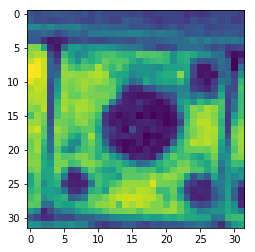

In [12]:
plt.imshow(X[0])

In [34]:
mask = np.isnan(training_regress)

In [35]:
regress_x = np.array(training_x)[~mask]

In [36]:
regress_y = np.array(training_regress)[~mask]

In [18]:
len(regress_y)

778

(array([98., 86., 81., 86., 54., 81., 61., 71., 80., 80.]),
 array([4.70829010e-03, 6.32456589e-01, 1.26020489e+00, 1.88795319e+00,
        2.51570148e+00, 3.14344978e+00, 3.77119808e+00, 4.39894638e+00,
        5.02669468e+00, 5.65444298e+00, 6.28219128e+00]),
 <a list of 10 Patch objects>)

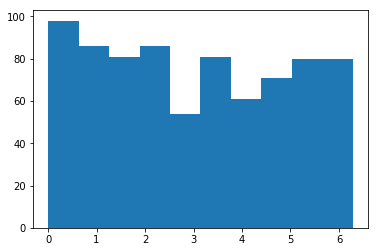

In [37]:
plt.hist(regress_y)